Load image and ImageNet classes list

In [ ]:
!wget -nc "https://ml.gan4x4.ru/msu/dev-2.1/Exercises/EX14/imagenet_class_index.json" -O imagenet_class_index.json
!wget -nc "https://ml.gan4x4.ru/msu/dev-1.9/L06/out/cat.jpg"


File ‘imagenet_class_index.json’ already there; not retrieving.
File ‘cat.jpg’ already there; not retrieving.



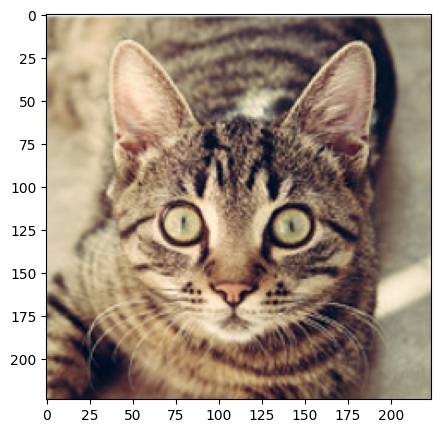

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def get_image(path):
    with open(os.path.abspath(path), "rb") as f:
        with Image.open(f) as img:
            return img.convert("RGB").resize((224,224))


img = get_image("cat.jpg")

plt.rcParams["figure.figsize"] = (5, 5)
plt.imshow(img)
plt.show()

Load ResNEt pretrained on ImageNet and Run inference

In [ ]:
import os
import torch
from torchvision import models
import json

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="ResNet18_Weights.DEFAULT")

idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath("/content/imagenet_class_index.json"), "r") as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    lable2idx = {class_idx[str(k)][1]: k for k in range(len(class_idx))}

In [ ]:
from torchvision.transforms import Resize, ToTensor, Compose, Normalize

transform = Compose(
        [
            ToTensor(),
            Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225))
        ])

model.to(device)
model.eval()
logits = model(transform(img).unsqueeze(0).to(device))

In [ ]:
import torch.nn.functional as F

def top_k_class(logits, k=6):
    prediction = F.softmax(logits, dim=1)
    top_props, top_inds = prediction.topk(k)

    for i in range(k):
        category_name = idx2label[top_inds[0][i].item()]
        score = top_props[0][i].item()
        print(f"{category_name} {top_inds[0][i].item()}: {100 * score:.1f}%")

    return top_props[0][0].item()


top_prop = top_k_class(logits)

Egyptian_cat 285: 49.2%
tabby 281: 38.0%
tiger_cat 282: 11.3%
remote_control 761: 0.2%
wood_rabbit 330: 0.1%
lynx 287: 0.1%


Perform attack

In [ ]:
from tqdm import tqdm

id = lable2idx["giant_panda"] # class name which logit we will maximize

ans_img = transform(img).clone()
ans_img = ans_img.to(device)
ans_img.requires_grad = True # Enable grad on image tensor, mode still in eval mode


optimizer = torch.optim.SGD([ans_img], # pass image tensot to optimizer
                            lr=0.05,
                            momentum=0.9,
                            maximize=True # swith optimizer objective to maximize
                            )
for i in (pbar := tqdm(range(20))):
    optimizer.zero_grad()
    logits = model(ans_img.unsqueeze(0))
    score = logits[:, id] # logit of "giant_panda" class
    score.backward() # Use logit value as loss but maximize it
    optimizer.step()
    pbar.set_description(f" Score for giant_panda {score.item():.2f}")

 Score for giant_panda 24.01: 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Model predict "giant_panda" with high probability!

In [ ]:
logits = model(ans_img.unsqueeze(0))
top_prop = top_k_class(logits)

giant_panda 388: 99.9%
polecat 358: 0.0%
Arctic_fox 279: 0.0%
capuchin 378: 0.0%
black-footed_ferret 359: 0.0%
white_wolf 270: 0.0%


But changed image look very similar to original:

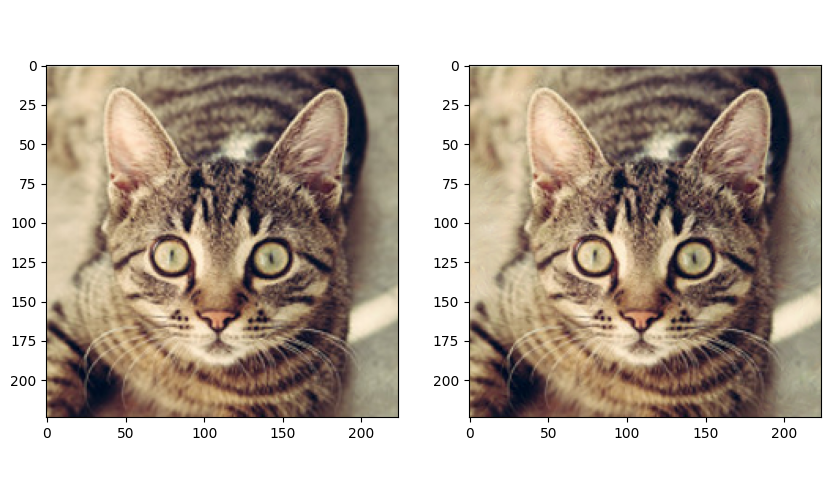

In [ ]:
import numpy as np

plt.rcParams["figure.figsize"] = (10,6)
plt.axis('off')

denormalize = Compose(
    [
        Normalize( mean=(0.0, 0.0, 0.0), std=(1 / 0.229, 1 / 0.224, 1 / 0.225)),
        Normalize( mean=(-0.485, -0.456, -0.406), std=(1.0, 1.0, 1.0))
    ])

img_np = denormalize(ans_img.cpu().detach()).permute(1,2,0).numpy()
img_np = np.clip(img_np, 0, 1)*255

plt.subplot(1,2,1)

plt.imshow(img)

plt.subplot(1,2,2)
plt.imshow(img_np.astype(np.uint8))
plt.show()






Look at the difference

Difference: mean 0.0032, std: 1.7045, max 15.614974975585938:.4f


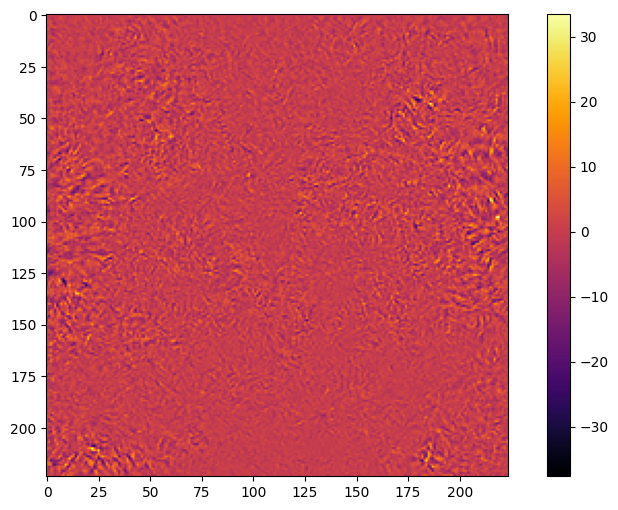

In [ ]:
diff = img - img_np
print(f"Difference: mean {diff.mean():.4f}, std: {diff.std():.4f}, max {diff.max()}:.4f")
heatmap = plt.imshow(diff.sum(axis=2),cmap="inferno")
plt.colorbar(heatmap)
plt.show()
